---
date: last-modified
---

# Creating a map that shows temperature values from POWER

### Notebook Authors / Affiliation

Ingrid Garcia-Solera, Daniel Kaufman / Atmospheric Science Data Center (ASDC)

In [1]:
import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np

## Load data

In [2]:
file_path = "T2M_and_PS.nc"
temperature_variable_name = "T2M"

In [3]:
with nc.Dataset(file_path, "r") as nc_file:
    # List all variables in the netCDF file.
    variables = nc_file.variables.keys()
    for variable_name in variables:
        print(f"Variable name: {variable_name}")

    # Get time.
    time_var = nc_file.variables["time"]
    time_array = time_var[:]
    print("\nTime variable:", time_var)
    print("\nTime array:", time_array)

    # Get temperature.
    temperature_var = nc_file.variables[temperature_variable_name]
    temperature_array_kelvin = temperature_var[:]
    print("\nTemperature variable:\n", temperature_var)

    # Get lat/lon coordinate pairs.
    lons = nc_file.variables["lon"][:]
    lats = nc_file.variables["lat"][:]

Variable name: T2M
Variable name: PS
Variable name: lat
Variable name: lon
Variable name: time

Time variable: <class 'netCDF4.Variable'>
int64 time(time)
    units: days since 1981-01-01
    calendar: proleptic_gregorian
unlimited dimensions: 
current shape = (10,)
filling on, default _FillValue of -9223372036854775806 used

Time array: [15491 15492 15493 15494 15495 15496 15497 15498 15499 15500]

Temperature variable:
 <class 'netCDF4.Variable'>
float64 T2M(time, lat, lon)
    _FillValue: nan
    long_name: Temperature at 2 Meters
    standard_name: Temperature_at_2_Meters
    units: K
    valid_max: 350.0
    valid_min: 150.0
    valid_range: [150. 350.]
unlimited dimensions: 
current shape = (10, 91, 193)
filling on


## Data wrangling

### Convert time to appropriate units

From above, we can see time is provided in `units: days since 1981-01-01`. We define a function in the next cell to add the `time` variable's values to a 1981 datetime object. This allows us to work with Python `datetime` objects in the subsequent plotting code.

In [4]:
def epic1981_to_datetime(days_in: int):
    """Convert days from 1981-01-01 to current timestamp."""
    datetime_obj = datetime.datetime(1981, 1, 1) + datetime.timedelta(days=days_in)

    return datetime_obj.strftime("%Y-%m-%d")


# Test that epic1981_to_datetime(15491) returns what we expect, that is, 2023-06-01.
print(epic1981_to_datetime(0))
print(epic1981_to_datetime(15491))

1981-01-01
2023-06-01


Now we apply the above function to convert all POWER dates to YYYY-MM-DD.

In [5]:
time_array = [epic1981_to_datetime(int(day)) for day in time_array]

print(time_array)

['2023-06-01', '2023-06-02', '2023-06-03', '2023-06-04', '2023-06-05', '2023-06-06', '2023-06-07', '2023-06-08', '2023-06-09', '2023-06-10']


### Convert temperature to appropriate units

From above, we can see that temperature is provided in `units: K`. In the next cell, we convert units of Kelvin to Celsius.

In [6]:
temperature_array_celsius = temperature_array_kelvin - 273.15

temperature_array_celsius.shape

(10, 91, 193)

Now we inspect the range of temperature values.

In [7]:
print(f"{temperature_array_celsius.min()} to {temperature_array_celsius.max()}")

-17.017187499999977 to 31.404687500000023


### Convert longitude and latitude to a 2D grid

In the next cell, we convert longitudes and latitudes each to a 2D grid so they match the grid shape of the temperature variable.

In [8]:
gridded_lon, gridded_lat = np.meshgrid(lons.data, lats.data)

print(gridded_lon.shape)
assert gridded_lon.shape == temperature_array_celsius.shape[1:]

(91, 193)


## Make contour plot

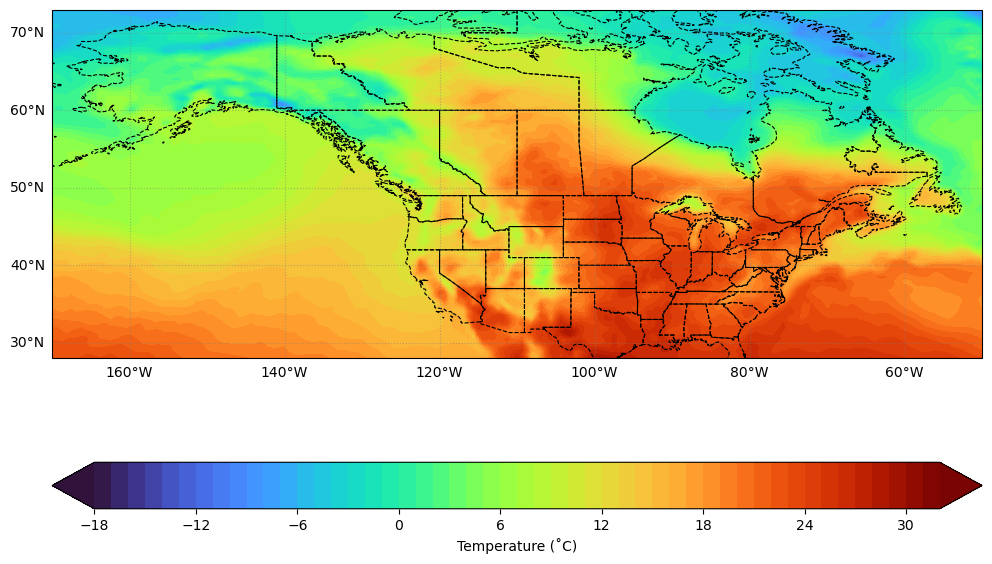

In [9]:
# Define the color range.
vmin, vmax = -18, 32
levels = 50
level_boundaries = np.linspace(vmin, vmax, levels + 1)

# Create the figure and axes.
projection = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(12, 9), subplot_kw={"projection": projection})

# Plot the data.
_contourf = ax.contourf(
    gridded_lon,
    gridded_lat,
    temperature_array_celsius[0, :, :],
    cmap="turbo",
    transform=projection,
    levels=level_boundaries,
    vmin=vmin,
    vmax=vmax,
    extend="both",
)

# Make it nice.
plt.colorbar(
    _contourf,
    ticks=range(int(np.floor(vmin)), int(np.ceil(vmax + 1)), 6),
    boundaries=level_boundaries,
    values=(level_boundaries[:-1] + level_boundaries[1:]) / 2,
    orientation="horizontal",
    label="Temperature (˚C)",
    ax=ax,
)
ax.add_feature(cfeature.STATES, linestyle="--", linewidth=0.8, edgecolor="k")
ax.gridlines(
    crs=projection,
    draw_labels=["left", "bottom"],
    linewidth=0.8,
    color="gray",
    alpha=0.5,
    linestyle=":",
)

# Explicitly tell matplotlib to show the figure here.
plt.show()